<a href="https://colab.research.google.com/github/Camel-light/Assignments/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following assignment consists of a theoretical part (learning portfolio) and a practical part (assignment). The goal is to build a classification model that predicts from which subject area a certain abstract originates. The plan would be that next week we will discuss your learnings from the theory part, that means you are relatively free to fill your Learning Portfolio on this new topic and in two weeks we will discuss your solutions of the Classification Model.

#Theory part (filling your Learning Portfolio, May 10)

In preparation for the practical part, I ask you to familiarize yourself with the following resources in the next week:

1) Please watch the following video:

https://course.fast.ai/Lessons/lesson4.html

You are also welcome to watch the accompanying Kaggle notebook if you like the video.

2) In addition to the video, I recommend you to read the first chapters of the course

https://huggingface.co/learn/nlp-course/chapter1/1


Try to understand principle processes and log them in your learning portfolio! A few suggestions: What is a pre-trained NLP model? How do I load them? What is tokenization? What does fine-tuning mean? What types of NLP Models are there? What possibilities do I have with the Transformers package? etc...

#Practical part (Assignment, May 17)

1) Preprocessing: The data which I provide as zip in Olat must be processed first, that means we need a table which has the following form:

Keywords | Title | Abstract | Research Field

The research field is determined by the name of the file.

2) We need a training dataset and a test dataset. My suggestion would be that for each research field we use the first 5700 lines for the training dataset and the last 300 lines for the test dataset. Please stick to this because then we can compare our models better!

3) Please use a pre-trained model from huggingface to build a classification model that tries to predict the correct research field from the 26. Please calculate the accuracy and the overall accuracy for all research fields. If you solve this task in a group, you can also try different pre-trained models. In addition to the abstracts, you can also see if the model improves if you include keywords and titles.

Some links, which can help you:

https://huggingface.co/docs/transformers/training

https://huggingface.co/docs/transformers/tasks/sequence_classification

One last request: Please always use PyTorch and not TensorFlow!

**Cleaning the data**

I cleaned the data first with the following python script. I had a problem with file "*MATH_1991-2000.csv*" on line 1061, because the *Title* filed had semicolons which caused problems. So, I encolosed the content in quoteation marks. Further, I had troubles splitting the data into 5700 / 300 for each field. First I confused and splitted each file into that ratio, but each file has only 2001 rows, then I still had troubles, so I just splitted by 95% / 5%, for train - & test - set, respectively.
Also, It looks like not all files contain a total of 6000 rows, for example the file "*HEAL_2001_2010.csv*" has 595 rows as opposed to 2001 like all other. I decided to fill the file with the 595th row up to 2001. 

Addition: Accuracy measures whether the research field with the highest probability value matches the target. With 26 research fields, it would also be interesting to know if the correct target is at least among the three highest probability values.

$\begin{pmatrix} A\\ B \\ C \\D \\E \end{pmatrix} = \begin{pmatrix} 0.1\\ 0.95 \\ 0.5 \\0.2 \\0.3 \end{pmatrix} → \text{Choice}_1 = B, \text{Choice}_3 = B,C,E$

In [104]:
# Run offline locally

'''
import os
import pandas as pd

folder_path = './data'  # Change this to the path of your folder
output_folder = './data_cleaned'  # Change this to the path of your output folder
counter = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        research_field = filename.split('_')[0]
        df['Research Field'] = research_field
        filtered_df = df[['Index Keywords', 'Title', 'Abstract', 'Research Field']]
        output_file_path = os.path.join(output_folder, filename)
        filtered_df.to_csv(output_file_path, index=False)
        counter += 1
        print(counter)
'''



"\nimport os\nimport pandas as pd\n\nfolder_path = './data'  # Change this to the path of your folder\noutput_folder = './data_cleaned'  # Change this to the path of your output folder\ncounter = 0\n\nfor filename in os.listdir(folder_path):\n    if filename.endswith('.csv'):\n        file_path = os.path.join(folder_path, filename)\n        df = pd.read_csv(file_path)\n        research_field = filename.split('_')[0]\n        df['Research Field'] = research_field\n        filtered_df = df[['Index Keywords', 'Title', 'Abstract', 'Research Field']]\n        output_file_path = os.path.join(output_folder, filename)\n        filtered_df.to_csv(output_file_path, index=False)\n        counter += 1\n        print(counter)\n"

Now the files have this structure

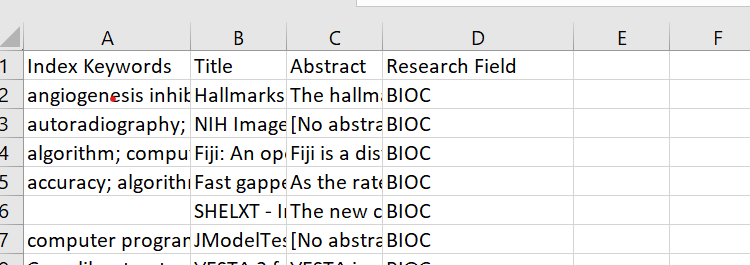

In [105]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# Get all the fields unique occurrences (set)
import os

def get_fields(directory):
    fields = set()
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            field = filename.split('_')[0]
            fields.add(field)
    return list(fields)


directory = '/content/drive/MyDrive/Colab_Notebooks/Lab6/data_cleaned'
fields = get_fields(directory)
print(fields)

['NEUR', 'DENT', 'DECI', 'IMMU', 'MEDI', 'PHYS', 'ENVI', 'HEAL', 'ARTS', 'EART', 'MATE', 'VETE', 'ECON', 'ENER', 'SOCI', 'BUSI', 'COMP', 'BIOC', 'ENGI', 'PSYC', 'CHEM', 'MATH', 'AGRI', 'NURS', 'PHAR', 'CENG']


In [107]:
# Get the data from each field, put first 95% rows into train_data and 5% into test_data

import pandas as pd
from sklearn.model_selection import train_test_split

def get_data(directory):
    train_dfs = []
    test_dfs = []

    for field in fields:
        field_files = [filename for filename in os.listdir(directory) if filename.startswith(field + "_")]
        field_train_dfs = []
        field_test_dfs = []
        
        for filename in field_files:
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            train_data, test_data = train_test_split(df, test_size=0.05, random_state=42)
            field_train_dfs.append(train_data)
            field_test_dfs.append(test_data)
        
        field_train_data = pd.concat(field_train_dfs)
        field_test_data = pd.concat(field_test_dfs)
        train_dfs.append(field_train_data)
        test_dfs.append(field_test_data)
    
    train_data = pd.concat(train_dfs)
    test_data = pd.concat(test_dfs)

  
    return train_data, test_data

train_data, test_data = get_data(directory)

In [109]:
train_data.describe()

,Index Keywords,Title,Abstract,Research Field
count,105035,146864,146864,146864
unique,104684,146528,138581,26
top,Animalia,Review of particle physics,[No abstract available],NEUR
freq,50,7,8252,5700


In [110]:
test_data.describe()

,Index Keywords,Title,Abstract,Research Field
count,5498,7730,7730,7730
unique,5492,7730,7275,26
top,article,Human neuronal nicotinic receptors,[No abstract available],NEUR
freq,3,1,456,300


In [111]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146864 entries, 916 to 1126
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Index Keywords  105035 non-null  object
 1   Title           146864 non-null  object
 2   Abstract        146864 non-null  object
 3   Research Field  146864 non-null  object
dtypes: object(4)
memory usage: 5.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7730 entries, 1860 to 1931
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Index Keywords  5498 non-null   object
 1   Title           7730 non-null   object
 2   Abstract        7730 non-null   object
 3   Research Field  7730 non-null   object
dtypes: object(4)
memory usage: 302.0+ KB


In [112]:
print(5700/6000)
print(146864 /(146864 + 7730))

# ~ 95% split

0.95
0.9499980594330957


In [113]:
# Many 'Index Keywords' fields are empty. Imputing with row above, only if it has the same research field, as they are about similar topics.

def fill_missing_keywords(df):
    prev_keywords = None
    prev_field = None
    filled_keywords = []
    for index, row in df.iterrows():
        keywords = row['Index Keywords']
        field = row['Research Field']
        if pd.isnull(keywords) and field == prev_field:
            filled_keywords.append(prev_keywords)
        else:
            filled_keywords.append(keywords)
            prev_keywords = keywords
        prev_field = field
    return filled_keywords

train_data['Index Keywords'] = fill_missing_keywords(train_data)
test_data['Index Keywords'] = fill_missing_keywords(test_data)

In [114]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146864 entries, 916 to 1126
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Index Keywords  146823 non-null  object
 1   Title           146864 non-null  object
 2   Abstract        146864 non-null  object
 3   Research Field  146864 non-null  object
dtypes: object(4)
memory usage: 5.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7730 entries, 1860 to 1931
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Index Keywords  7702 non-null   object
 1   Title           7730 non-null   object
 2   Abstract        7730 non-null   object
 3   Research Field  7730 non-null   object
dtypes: object(4)
memory usage: 302.0+ KB


Now there are less null rows for Index Keywords (more non-null rows)

In [117]:
    # Impute empty Abstract rows with Title + Index Keywords
    train_data = train_data.reset_index(drop=True)
    train_data.loc[train_data['Abstract'] == '[No abstract available]', 'Abstract'] = train_data['Title'] + ' ' + train_data['Index Keywords']
    test_data = test_data.reset_index(drop=True)
    test_data.loc[test_data['Abstract'] == '[No abstract available]', 'Abstract'] = test_data['Title'] + ' ' + test_data['Index Keywords']

In [116]:
print(train_data[train_data['Abstract'] == '[No abstract available]'])
print(test_data[test_data['Abstract'] == '[No abstract available]'])


Empty DataFrame
Columns: [Index Keywords, Title, Abstract, Research Field]
Index: []
Empty DataFrame
Columns: [Index Keywords, Title, Abstract, Research Field]
Index: []


In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Split into training and validation using stratified sampling
train_data, validation_data = train_test_split(train_data, test_size=0.15, stratify=train_data['Research Field'], random_state=42)

print("Length of training, validation and test set")
print((len(train_data), len(validation_data), len(test_data)))

Length of training, validation and test set
(124834, 22030, 7730)


In [125]:
!pip install transformers==4.28.0
!pip install accelerate
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.2
    Uninstalling transformers-4.29.2:
      Successfully uninstalled transformers-4.29.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer
from datasets import Dataset,DatasetDict

# Make data comply to transformers standard: text and labels
train_data_transformers = train_data.loc[:, ['Abstract', 'Research Field']]
train_data_transformers.columns = ['text', 'labels']
test_data_transformers = test_data.loc[:, ['Abstract', 'Research Field']]
test_data_transformers.columns = ['text', 'labels']
valid_data_transformers = validation_data.loc[:, ['Abstract', 'Research Field']]
valid_data_transformers.columns = ['text', 'labels']

# convert to datasets
train_ds = Dataset.from_pandas(train_data_transformers)
valid_ds = Dataset.from_pandas(valid_data_transformers)
test_ds = Dataset.from_pandas(test_data_transformers)

dataset_dict = DatasetDict({'train': train_ds, 'validation': valid_ds, 'test': test_ds})

# model and tokenizer definition
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

id2label = {1: 'DENT', 2: 'AGRI', 3: 'ENER', 4: 'PSYC', 5: 'DECI', 6: 'VETE', 7: 'PHAR', 8: 'MATH',
       9: 'NURS', 10: 'ECON', 11: 'COMP', 12: 'ARTS', 13: 'CENG', 14: 'ENVI', 15: 'SOCI', 16: 'BIOC',
       17: 'MATE', 18: 'CHEM', 19: 'HEAL', 20: 'ENGI', 21: 'BUSI', 22: 'NEUR', 23: 'MEDI', 24: 'IMMU',
       25: 'PHYS', 0: 'EART'}
label2id = {value: key for key, value in id2label.items()}

# tokenize text and convert labels into labekl id
def tokenize_function(x):
    tokens = tokenizer(str(x['text']), truncation=True, padding="max_length")
    tokens["labels"] = [label2id[label] for label in x["labels"]]
    return tokens

In [ ]:
for split_name, dataset in dataset_dict.items():
    print(f'{split_name} split:')
    print(f'input_ids length: {dataset.features["input_ids"].length}')

In [ ]:
def print_none_or_empty_strings(input_list):
    for i, x in enumerate(input_list):
        if x is None or x == '':
            print(f'Index: {i}, Value: {x}')

print_none_or_empty_strings(train_ds)

from datasets import DatasetDict

def check_dataset(dataset_dict: DatasetDict):
    for split_name, dataset in dataset_dict.items():
        print(f'Checking {split_name} split...')
        column_names = dataset.column_names
        if 'text' not in column_names:
            print(f'Error: {split_name} split does not have a "text" column.')
        else:
            text_column = dataset['text']
            for i, text in enumerate(text_column):
                if not isinstance(text, str):
                    print(f'Error: Element at index {i} in the "text" column of the {split_name} split is not a string.')
                
check_dataset(dataset_dict)

In [ ]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

In [ ]:
from transformers import BertForSequenceClassification
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("/content/drive/MyDrive/Colab_Notebooks/Lab6/checkpoint_research/", evaluation_strategy="epoch", per_device_train_batch_size=8, per_device_eval_batch_size=8)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=26, id2label=id2label, label2id=label2id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train(resume_from_checkpoint=True)

OLD
========================================================================================================================================================

In [ ]:
from torch.utils.data import Dataset

# Define a function to preprocess the data
def preprocess(data, batch_size=1000):
    input_features = ['Title']
    input_text = data[input_features].iloc[:,0]
    labels = data['Research Field']
    
    # Tokenize the input text in batches
    encodings = {'input_ids': [], 'attention_mask': [], 'token_type_ids': []}
    for i in range(0, len(input_text), batch_size):
        batch = input_text[i:i+batch_size]
        batch_encodings = tokenizer(batch.to_list(), truncation=True, padding=True)
        encodings['input_ids'].extend(batch_encodings['input_ids'])
        encodings['attention_mask'].extend(batch_encodings['attention_mask'])
        if 'token_type_ids' in batch_encodings:
            encodings['token_type_ids'].extend(batch_encodings['token_type_ids'])
    
    return encodings, labels

# Preprocess the training and test data
train_encodings, train_labels = preprocess(train_data)
test_encodings, test_labels = preprocess(test_data)

# Convert the labels to a NumPy array
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

# Convert the data to a format that can be used by the Trainer
train_data = CustomDataset(train_encodings, train_labels)
test_data = CustomDataset(test_encodings, test_labels)

# Convert the data to a format that can be used by the Trainer
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_data = CustomDataset(train_encodings, train_labels)
test_data = CustomDataset(test_encodings, test_labels)

In [ ]:
print(f"Type of train_labels: {type(train_labels)}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Type of test_labels: {type(test_labels)}")
print(f"Shape of test_labels: {test_labels.shape}")

In [ ]:
def analyze_dataset(dataset):
    # Check if the dataset has a 'labels' key
    if 'labels' not in dataset[0]:
        print("The dataset does not contain a 'labels' key.")
    else:
        print("The dataset contains a 'labels' key.")
        # Check the shape of the labels
        labels_shape = dataset[0]['labels'].shape
        print(f"The shape of the labels is: {labels_shape}")

# Analyze the training and test datasets
print("Analyzing the training dataset:")
analyze_dataset(train_data)
print("\nAnalyzing the test dataset:")
analyze_dataset(test_data)

In [ ]:
from transformers import TrainingArguments, Trainer
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    logging_dir='./logs',
)

# Create a Trainer and fine-tune the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)
trainer.train()

In [ ]:
# Evaluate the model on the test data
results = trainer.evaluate()
print(f'Overall accuracy: {results["eval_accuracy"]}')